# Verifying the SpeechT5 TTS model

I needed to do the following to be able to load the original model:

- Clone the https://github.com/microsoft/SpeechT5 repo

Install stuff:

```
pip install editdistance
pip install -U sacrebleu==1.5.1

git submodule update --init SpeechT5/fairseq
cd SpeechT5
pip install --editable fairseq/
pip install espnet
```

Hack the code:

- Copy `speecht5/tasks/speecht5.py` into `fairseq/fairseq/tasks`

- `checkpoint_utils.py`: comment out a bunch of the loading stuff because of missing keys in the checkpoint

Additional stuff to download:

- `dict.txt` from https://drive.google.com/uc?export=download&id=19hcQ58RHZ6CssxF8Qp6yEF1NW_AXxObK

- `tokenizer` from https://drive.google.com/uc?export=download&id=1wClgQjXXoU2lmpbaEa1v2SqMbg7cAutq

- `xvectors.zip` from https://drive.google.com/uc?export=download&id=16QOUURZBrW7-GYbVG_gXt3mTMlZmQoH0

- everything from https://huggingface.co/mechanicalsea/speecht5-tts

- https://github.com/kan-bayashi/ParallelWaveGAN

**!!! IMPORTANT !!!**

As is, the outputs from the original model and the Hugging Face implementation do not match for the same inputs. This happens because the speech decoder prenet *always* applies dropout, even when not training. Every time you run the (decoder part of the) model, the output will be slightly different.

To test that both models give exactly the same output (max absolute error of ~1e-6), do the following:

- In `modeling_speecht5.py`, in `SpeechT5SpeechDecoderPrenet.forward`, set `training=False` on the two dropout layers.

- In espnet, in `nets/pytorch_backend/tacotron2/decoder.py`, in `Prenet.forward` add `training=False` on the dropout layer.

In [1]:
%reload_ext autoreload
%autoreload 2

Set Python path so it can find the `speecht5` and `fairseq` modules.

In [2]:
import sys
sys.path.insert(0, "../SpeechT5/SpeechT5")
sys.path.insert(0, "../SpeechT5/SpeechT5/fairseq")

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt

## Tokenize input text

In [4]:
from argparse import Namespace
from fairseq.data import encoders

bpe_tokenizer_path = "/Users/matthijs/Documents/FILES/HuggingFace/SpeechT5/tryout/MODEL_DIR/spm_char.model"
tokenizer = encoders.build_bpe(Namespace(**{"bpe": "sentencepiece", "sentencepiece_model": bpe_tokenizer_path}))

In [5]:
from fairseq.data import Dictionary
src_dict = Dictionary.load("/Users/matthijs/Documents/FILES/HuggingFace/SpeechT5/tryout/DATA_ROOT/dict.txt")
src_dict.add_symbol("<mask>")
src_dict.add_symbol("<ctc_blank>")
print(f"dictionary size: " f"{len(src_dict):,}")

dictionary size: 81


In [6]:
from fairseq.tasks.hubert_pretraining import LabelEncoder
label_processor = LabelEncoder(src_dict)

In [7]:
text = "Hey, what's up, Hugging Face? This is Speech tee five talking to you for real."

In [8]:
label = tokenizer.encode(text)
label

"▁ H e y , ▁ w h a t ' s ▁ u p , ▁ H u g g i n g ▁ F a c e ? ▁ T h i s ▁ i s ▁ S p e e c h ▁ t e e ▁ f i v e ▁ t a l k i n g ▁ t o ▁ y o u ▁ f o r ▁ r e a l ."

In [9]:
src_tokens = label_processor(label).unsqueeze(0)
src_tokens

tensor([[ 4, 35,  5, 22, 23,  4, 20, 11,  7,  6, 31, 12,  4, 16, 24, 23,  4, 35,
         16, 21, 21, 10,  9, 21,  4, 55,  7, 17,  5, 41,  4, 32, 11, 10, 12,  4,
         10, 12,  4, 34, 24,  5,  5, 17, 11,  4,  6,  5,  5,  4, 19, 10, 27,  5,
          4,  6,  7, 15, 28, 10,  9, 21,  4,  6,  8,  4, 22,  8, 16,  4, 19,  8,
         13,  4, 13,  5,  7, 15, 26]], dtype=torch.int32)

In [10]:
# src_tokens = torch.tensor([[
#     4, 35,  5, 22, 23,  4, 20, 11,  7,  6, 31, 12,  4, 16, 24, 23,  4, 35,
#          16, 21, 21, 10,  9, 21,  4, 55,  7, 17,  5, 41,  4, 32, 11, 10, 12,  4,
#          10, 12,  4, 34, 24,  5,  5, 17, 11,  4,  6,  5,  5,  4, 19, 10, 27,  5,
#           4,  6,  7, 15, 28, 10,  9, 21,  4,  6,  8,  4, 22,  8, 16,  4, 19,  8,
#          13,  4, 13,  5,  7, 15, 26
# ]])

In [11]:
attention_mask = torch.ones_like(src_tokens)
attention_mask.shape

torch.Size([1, 79])

In [12]:
text2 = "A much shorter snippet"
label2 = tokenizer.encode(text2)
src_tokens2 = label_processor(label2).unsqueeze(0)
src_tokens2

tensor([[ 4, 33,  4, 18, 16, 17, 11,  4, 12, 11,  8, 13,  6,  5, 13,  4, 12,  9,
         10, 24, 24,  5,  6]], dtype=torch.int32)

In [13]:
pad_token_id = 1
pad_length = src_tokens.size(-1) - src_tokens2.size(-1)
src_tokens2_padded = torch.cat([src_tokens2, torch.ones(1, pad_length).long() * pad_token_id], dim=1)
attention_mask2 = torch.cat([torch.ones_like(src_tokens2), torch.zeros(1, pad_length).long()], dim=1)

In [14]:
# input_ids_batch = torch.cat([src_tokens, src_tokens2_padded])
# attention_mask_batch = torch.cat([attention_mask, attention_mask2])

In [15]:
# input_ids_batch = torch.cat([src_tokens2_padded, src_tokens])
# attention_mask_batch = torch.cat([attention_mask2, attention_mask])

In [16]:
input_ids_batch = torch.cat([src_tokens, src_tokens2_padded, src_tokens.clone()])
attention_mask_batch = torch.cat([attention_mask, attention_mask2, attention_mask.clone()])

In [17]:
from transformers import SpeechT5Tokenizer

In [18]:
model_checkpoint = "/Users/matthijs/Documents/FILES/HuggingFace/SpeechT5/weights/speecht5_tts"
hf_tokenizer = SpeechT5Tokenizer.from_pretrained(model_checkpoint)
hf_tokenizer

PreTrainedTokenizer(name_or_path='/Users/matthijs/Documents/FILES/HuggingFace/SpeechT5/weights/speecht5_tts', vocab_size=79, model_max_len=600, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>'})

In [19]:
texts = [text, text2]
encoded = hf_tokenizer(texts, padding=True, return_tensors="pt")
hf_input_ids_batch = encoded["input_ids"]
hf_attention_mask_batch = encoded["attention_mask"]

In [20]:
hf_input_ids_batch

tensor([[ 4, 35,  5, 22, 23,  4, 20, 11,  7,  6, 31, 12,  4, 16, 24, 23,  4, 35,
         16, 21, 21, 10,  9, 21,  4, 55,  7, 17,  5, 41,  4, 32, 11, 10, 12,  4,
         10, 12,  4, 34, 24,  5,  5, 17, 11,  4,  6,  5,  5,  4, 19, 10, 27,  5,
          4,  6,  7, 15, 28, 10,  9, 21,  4,  6,  8,  4, 22,  8, 16,  4, 19,  8,
         13,  4, 13,  5,  7, 15, 26],
        [ 4, 33,  4, 18, 16, 17, 11,  4, 12, 11,  8, 13,  6,  5, 13,  4, 12,  9,
         10, 24, 24,  5,  6,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1]])

## Mel spectrograms

In [24]:
from transformers import SpeechT5SpectrogramFeatureExtractor
# from transformers.models.speecht5.feature_extraction_speecht5 import SpeechT5SpectrogramFeatureExtractor

In [35]:
import soundfile as sf
raw_speech, sample_rate = sf.read("/Users/matthijs/Downloads/LibriTTS_16k/test-clean/908/31957/908_31957_000002_000000.wav")
raw_speech.shape, sample_rate

((10080,), 16000)

In [74]:
raw_speech.min(), raw_speech.max()

(-0.324310302734375, 0.4176025390625)

In [75]:
feature_extractor = SpeechT5SpectrogramFeatureExtractor()

In [76]:
encoded = feature_extractor(raw_speech, sampling_rate=sample_rate)
{k:v[0].shape for k,v in encoded.items()}

{'input_features': (39, 80), 'attention_mask': (39,)}

In [77]:
encoded

{'input_features': array([[[ 7.727417 ,  8.016721 ,  6.5607743, ...,  9.046635 ,
          9.182222 ,  9.0145   ],
        [ 7.3097887,  7.856609 ,  6.9497666, ..., 10.303231 ,
          9.919563 ,  9.640942 ],
        [ 8.720597 ,  9.217327 ,  8.735426 , ..., 10.997007 ,
         10.655799 , 10.4858885],
        ...,
        [ 6.3238945,  5.873545 ,  5.3010244, ...,  8.013116 ,
          7.8191676,  7.4225516],
        [ 5.860345 ,  6.2634892,  5.6213355, ...,  7.804258 ,
          7.6991596,  7.3007116],
        [ 6.10927  ,  6.3839307,  5.984153 , ...,  7.819647 ,
          7.6049223,  6.9310064]]], dtype=float32), 'attention_mask': [array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)]}

In [42]:
fbank = np.load("/Users/matthijs/Documents/FILES/HuggingFace/SpeechT5/SpeechT5/SpeechT5/fbank.npy")
fbank.shape

(40, 80)

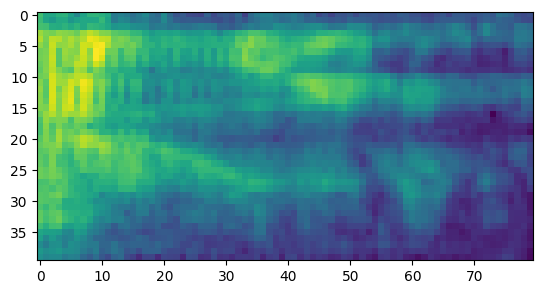

In [43]:
plt.imshow(fbank)

In [79]:
fbank.min(), fbank.max()

(-4.2309704, 0.15604725)

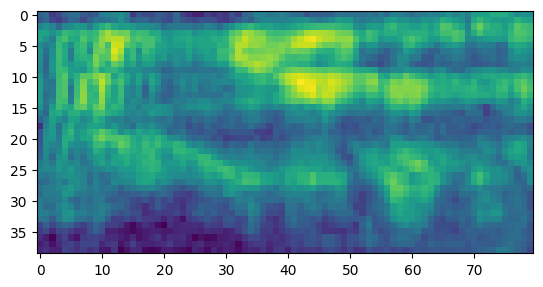

In [80]:
plt.imshow(encoded["input_features"][0])

In [81]:
encoded["input_features"][0].min(), encoded["input_features"][0].max()

(5.2308874, 13.056992)

In [84]:
from transformers import AutoProcessor
processor = AutoProcessor.from_pretrained(model_checkpoint)
processor

SpeechT5ProcessorForTextToSpeech:
- feature_extractor: SpeechT5SpectrogramFeatureExtractor {
  "feature_extractor_type": "SpeechT5SpectrogramFeatureExtractor",
  "feature_size": 80,
  "num_mel_bins": 80,
  "padding_side": "right",
  "padding_value": 0.0,
  "processor_class": "SpeechT5ProcessorForTextToSpeech",
  "return_attention_mask": true,
  "sampling_rate": 16000
}

- tokenizer: PreTrainedTokenizer(name_or_path='/Users/matthijs/Documents/FILES/HuggingFace/SpeechT5/weights/speecht5_tts', vocab_size=79, model_max_len=600, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>'})

In [91]:
inputs_test = processor(text, padding=True, return_tensors="pt")
inputs_test

{'input_ids': tensor([[ 4, 35,  5, 22, 23,  4, 20, 11,  7,  6, 31, 12,  4, 16, 24, 23,  4, 35,
         16, 21, 21, 10,  9, 21,  4, 55,  7, 17,  5, 41,  4, 32, 11, 10, 12,  4,
         10, 12,  4, 34, 24,  5,  5, 17, 11,  4,  6,  5,  5,  4, 19, 10, 27,  5,
          4,  6,  7, 15, 28, 10,  9, 21,  4,  6,  8,  4, 22,  8, 16,  4, 19,  8,
         13,  4, 13,  5,  7, 15, 26]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1]])}

In [90]:
inputs_test = processor(audio=raw_speech, sampling_rate=sample_rate, padding=True, return_tensors="pt")
inputs_test

{'input_values': tensor([[[ 7.7274,  8.0167,  6.5608,  ...,  9.0466,  9.1822,  9.0145],
         [ 7.3098,  7.8566,  6.9498,  ..., 10.3032,  9.9196,  9.6409],
         [ 8.7206,  9.2173,  8.7354,  ..., 10.9970, 10.6558, 10.4859],
         ...,
         [ 6.3239,  5.8735,  5.3010,  ...,  8.0131,  7.8192,  7.4226],
         [ 5.8603,  6.2635,  5.6213,  ...,  7.8043,  7.6992,  7.3007],
         [ 6.1093,  6.3839,  5.9842,  ...,  7.8196,  7.6049,  6.9310]]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=torch.int32)}

## Load the Transformers model

To convert the original checkpoint weights to Transformers:

First download the checkpoint from https://huggingface.co/mechanicalsea/speecht5-tts

Then run the following, using your own `--checkpoint_path` and `--pytorch_dump_folder_path`:

```nohighlight
cd transformers/src/transformers/models/speecht5

python convert_speecht5_original_pytorch_checkpoint_to_pytorch.py \
  --task t2s \
  --checkpoint_path /path/to/SpeechT5/speecht5_tts.pt
  --pytorch_dump_folder_path /some/other/path
```

In [21]:
from transformers import (
    SpeechT5Config, 
    SpeechT5Processor,
    SpeechT5Model, 
    SpeechT5ForTextToSpeech,
)

In [22]:
# config = SpeechT5Config()
# hf_model = SpeechT5Model(config)

In [23]:
model_checkpoint = "/Users/matthijs/Documents/FILES/HuggingFace/SpeechT5/weights/speecht5_tts"

In [24]:
hf_model = SpeechT5ForTextToSpeech.from_pretrained(model_checkpoint)

In [25]:
hf_model.eval()

SpeechT5ForTextToSpeech(
  (speecht5): SpeechT5Model(
    (encoder): SpeechT5EncoderWithTextPrenet(
      (prenet): SpeechT5TextEncoderPrenet(
        (embed_tokens): Embedding(81, 768, padding_idx=1)
        (encode_positions): SpeechT5ScaledPositionalEncoding(
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (wrapped_encoder): SpeechT5Encoder(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (layers): ModuleList(
          (0): SpeechT5EncoderLayer(
            (attention): SpeechT5Attention(
              (k_proj): Linear(in_features=768, out_features=768, bias=True)
              (v_proj): Linear(in_features=768, out_features=768, bias=True)
              (q_proj): Linear(in_features=768, out_features=768, bias=True)
              (out_proj): Linear(in_features=768, out_features=768, bias=True)
            )
            (dropout): Dropout(p=0.1, inplace=False)
            (

In [35]:
# Loading should work OK for class `SpeechT5Model` too:
hf_model_naked = SpeechT5Model.from_pretrained(model_checkpoint)

Some weights of the model checkpoint at /Users/matthijs/Documents/FILES/HuggingFace/SpeechT5/weights/speecht5_tts were not used when initializing SpeechT5Model: ['speech_decoder_postnet.layers.3.conv.weight', 'speech_decoder_postnet.layers.4.conv.weight', 'speecht5.decoder.prenet.layer2.bias', 'speecht5.decoder.prenet.encode_positions.pe', 'speecht5.encoder.prenet.encode_positions.pe', 'speecht5.decoder.prenet.layer1.weight', 'speech_decoder_postnet.layers.2.batch_norm.weight', 'speecht5.decoder.prenet.speaker_embeds_layer.bias', 'speech_decoder_postnet.layers.3.batch_norm.running_mean', 'speech_decoder_postnet.prob_out.bias', 'speech_decoder_postnet.layers.0.conv.weight', 'speech_decoder_postnet.layers.2.batch_norm.num_batches_tracked', 'speecht5.decoder.prenet.layer3.weight', 'speech_decoder_postnet.layers.3.batch_norm.weight', 'speech_decoder_postnet.layers.1.batch_norm.num_batches_tracked', 'speech_decoder_postnet.layers.1.conv.weight', 'speech_decoder_postnet.prob_out.weight', 'sp

## Load the original model

See the script `generate_speech.py` from the SpeechT5 repo.

Load the dictionary. This adds `<s>, <pad>, </s>, <unk>` tokens to the front and `<mask>` and `<ctc_blank>` to the end. **dict.txt** was [downloaded from here](https://drive.google.com/uc?export=download&id=19hcQ58RHZ6CssxF8Qp6yEF1NW_AXxObK). This is the Vocabulary link from the main SpeechT5 README.

In [36]:
from fairseq.data import Dictionary
tgt_dict = Dictionary.load("/Users/matthijs/Documents/FILES/HuggingFace/SpeechT5/tryout/DATA_ROOT/dict.txt")
tgt_dict.add_symbol("<mask>")
tgt_dict.add_symbol("<ctc_blank>")
print(f"dictionary size: " f"{len(tgt_dict):,}")

dictionary size: 81


To load the model we need the `SpeechT5Task` object but constructing it is annoying. Fortunately, `build_model` only reads two properties from the task object, so we can fake it.

In [37]:
class FakeTask:
    def __init__(self):
        self.dicts = { "text": tgt_dict }
        self.t5_task = "t2s"
        
task = FakeTask()

Load the fine-tuned ASR model.

In [38]:
import torch
from speecht5.models.speecht5 import T5TransformerModel

In [39]:
checkpoint = torch.load("../weights/speecht5-tts/speecht5_tts.pt")

orig_model = T5TransformerModel.build_model(checkpoint["cfg"]["model"], task)

orig_model.load_state_dict(checkpoint["model"])
orig_model = orig_model.eval()

In [40]:
type(orig_model)

speecht5.models.speecht5.T5TransformerModel

In [41]:
type(orig_model.encoder)

speecht5.models.modules.encoder.TransformerEncoder

In [42]:
#list(checkpoint["model"].keys())

In [43]:
from fairseq.data import encoders
from argparse import Namespace
tokenizer = encoders.build_bpe(
    Namespace(
        bpe='sentencepiece', 
        sentencepiece_model='/Users/matthijs/Documents/FILES/HuggingFace/SpeechT5/tryout/MODEL_DIR/spm_char.model'
    )
)
type(tokenizer)

fairseq.data.encoders.sentencepiece_bpe.SentencepieceBPE

In [44]:
# orig_model.decoder.layers[0].encoder_attn

## Verify text encoder prenet output

The `text_encoder_prenet` converts the input tokens into embeddings of shape `(batch, sequence_length, 768)`.

In [33]:
with torch.no_grad():
    encoder_input, encoder_padding_mask = orig_model.text_encoder_prenet(src_tokens)

In [34]:
with torch.no_grad():
    encoder_input, encoder_padding_mask = orig_model.text_encoder_prenet(input_ids_batch)

In [35]:
encoder_input.shape, encoder_padding_mask.shape

(torch.Size([3, 79, 768]), torch.Size([3, 79]))

In [36]:
encoder_input

tensor([[[-0.0383,  0.0826,  0.0607,  ..., -0.0333, -0.1770,  0.0203],
         [ 0.0857,  0.0239,  0.2346,  ...,  0.1588,  0.0084,  0.0664],
         [ 0.0644,  0.0361,  0.2011,  ..., -0.0519, -0.1996,  0.0747],
         ...,
         [ 0.1361,  0.1569, -0.1022,  ...,  0.1605,  0.0147,  0.0804],
         [ 0.2444, -0.0554, -0.0303,  ...,  0.0666,  0.0143, -0.0211],
         [ 0.0408, -0.0834,  0.1128,  ...,  0.1641, -0.0404,  0.0649]],

        [[-0.0383,  0.0826,  0.0607,  ..., -0.0333, -0.1770,  0.0203],
         [ 0.0265, -0.0583,  0.1753,  ...,  0.1945, -0.0829,  0.0322],
         [ 0.0574, -0.0665,  0.1584,  ..., -0.0333, -0.1770,  0.0203],
         ...,
         [ 0.0329,  0.0656, -0.0175,  ...,  0.1879, -0.0242,  0.1195],
         [ 0.0786, -0.0244,  0.0573,  ...,  0.1879, -0.0242,  0.1195],
         [ 0.0274, -0.1115,  0.1526,  ...,  0.1879, -0.0242,  0.1195]],

        [[-0.0383,  0.0826,  0.0607,  ..., -0.0333, -0.1770,  0.0203],
         [ 0.0857,  0.0239,  0.2346,  ...,  0

In [37]:
encoder_padding_mask

tensor([[False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True, 

In [38]:
((1.0 - encoder_padding_mask * 1.0) - attention_mask_batch).sum()

tensor(0.)

Run Hugging Face model:

In [39]:
with torch.no_grad():
     hf_outputs = hf_model.speecht5.encoder.prenet(src_tokens)

type(hf_outputs)

torch.Tensor

In [40]:
with torch.no_grad():
     hf_outputs = hf_model.speecht5.encoder.prenet(input_ids_batch)

type(hf_outputs)

torch.Tensor

In [41]:
hf_outputs.shape

torch.Size([3, 79, 768])

In [42]:
hf_outputs[0]

tensor([[-0.0383,  0.0826,  0.0607,  ..., -0.0333, -0.1770,  0.0203],
        [ 0.0857,  0.0239,  0.2346,  ...,  0.1588,  0.0084,  0.0664],
        [ 0.0644,  0.0361,  0.2011,  ..., -0.0519, -0.1996,  0.0747],
        ...,
        [ 0.1361,  0.1569, -0.1022,  ...,  0.1605,  0.0147,  0.0804],
        [ 0.2444, -0.0554, -0.0303,  ...,  0.0666,  0.0143, -0.0211],
        [ 0.0408, -0.0834,  0.1128,  ...,  0.1641, -0.0404,  0.0649]])

In [43]:
hf_encoder_input = hf_outputs

If the weights and model were converted correctly, this should report zero or a very small number:

In [44]:
torch.max(torch.abs(encoder_input - hf_outputs))

tensor(0.)

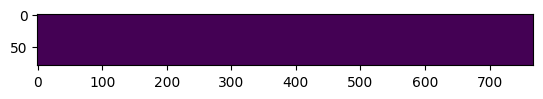

In [45]:
plt.imshow(torch.abs(encoder_input - hf_outputs).numpy()[0])

In [46]:
# plt.imshow(torch.abs(encoder_input - hf_outputs).numpy()[1])

## Verify Transformer encoder output

In [46]:
# Run it with the original's speech prenet input:
with torch.no_grad():
    encoder_output = orig_model.encoder(encoder_input, encoder_padding_mask)

In [47]:
print("encoder_out shape", encoder_output["encoder_out"][0].shape)
print("encoder_padding_mask shape", encoder_output["encoder_padding_mask"][0].shape)
print("encoder_states", encoder_output["encoder_states"])  # []
print("src_tokens", encoder_output["src_tokens"])  # []
print("decoder_input", encoder_output["decoder_input"])  # [None]
print("encoder_out_for_ctc shape", encoder_output["encoder_out_for_ctc"][0].shape)

encoder_out shape torch.Size([79, 3, 768])
encoder_padding_mask shape torch.Size([3, 79])
encoder_states []
src_tokens []
decoder_input [None]
encoder_out_for_ctc shape torch.Size([79, 3, 81])


In [48]:
encoder_output["encoder_out"][0].permute((1, 0, 2))

tensor([[[ 0.1216, -0.1223, -0.0161,  ...,  0.1346,  0.0016, -0.0969],
         [-0.4308,  0.2260,  0.2156,  ..., -0.1011,  0.0140, -0.4570],
         [-0.5038,  0.2883,  0.1684,  ...,  0.0300, -0.0678, -0.4736],
         ...,
         [ 0.4783, -0.1476, -0.0570,  ..., -0.2642, -0.6181,  0.2321],
         [ 0.4313, -0.2115, -0.1195,  ..., -0.4216, -0.4153,  0.2950],
         [ 0.0910, -0.0379,  0.1903,  ...,  0.0070, -0.1593, -0.0444]],

        [[ 0.0905, -0.1641, -0.0431,  ...,  0.0498, -0.1105, -0.0655],
         [-0.0920, -0.5321, -0.3698,  ..., -0.2545,  0.2266, -0.3704],
         [-0.1659, -0.5388, -0.3071,  ..., -0.2132,  0.2163, -0.4686],
         ...,
         [-0.0044, -0.0316,  0.1062,  ..., -0.0323, -0.1612,  0.0196],
         [-0.0057, -0.0386,  0.1017,  ..., -0.0345, -0.1654,  0.0178],
         [-0.0060, -0.0436,  0.0920,  ..., -0.0345, -0.1679,  0.0209]],

        [[ 0.1216, -0.1223, -0.0161,  ...,  0.1346,  0.0016, -0.0969],
         [-0.4308,  0.2260,  0.2156,  ..., -0

In [49]:
# encoder_output["encoder_out_for_ctc"][0].permute((1, 0, 2))

In [50]:
# Use exact same inputs as the original model:
# with torch.no_grad():
#      hf_outputs = hf_model.speecht5(
#          inputs_embeds=encoder_input,
#          attention_mask=(~encoder_padding_mask),
#      )

# type(hf_outputs)

In [51]:
hf_encoder_input.shape

torch.Size([3, 79, 768])

In [52]:
with torch.no_grad():
     hf_outputs = hf_model.speecht5.encoder.wrapped_encoder(
         hidden_states=hf_encoder_input,
#          attention_mask=attention_mask,
         attention_mask=attention_mask_batch,
#          attention_mask=(1.0 - encoder_padding_mask * 1.0),
         return_dict=True,
     )

type(hf_outputs)

transformers.modeling_outputs.BaseModelOutput

In [53]:
hf_outputs

BaseModelOutput(last_hidden_state=tensor([[[ 0.1216, -0.1223, -0.0161,  ...,  0.1346,  0.0016, -0.0969],
         [-0.4308,  0.2260,  0.2156,  ..., -0.1011,  0.0140, -0.4570],
         [-0.5038,  0.2883,  0.1684,  ...,  0.0300, -0.0678, -0.4736],
         ...,
         [ 0.4783, -0.1476, -0.0570,  ..., -0.2642, -0.6181,  0.2321],
         [ 0.4313, -0.2115, -0.1195,  ..., -0.4216, -0.4153,  0.2950],
         [ 0.0910, -0.0379,  0.1903,  ...,  0.0070, -0.1593, -0.0444]],

        [[ 0.0905, -0.1641, -0.0431,  ...,  0.0498, -0.1105, -0.0655],
         [-0.0920, -0.5321, -0.3698,  ..., -0.2545,  0.2266, -0.3704],
         [-0.1659, -0.5388, -0.3071,  ..., -0.2132,  0.2163, -0.4686],
         ...,
         [-0.0044, -0.0316,  0.1062,  ..., -0.0323, -0.1612,  0.0196],
         [-0.0057, -0.0386,  0.1017,  ..., -0.0345, -0.1654,  0.0178],
         [-0.0060, -0.0436,  0.0920,  ..., -0.0345, -0.1679,  0.0209]],

        [[ 0.1216, -0.1223, -0.0161,  ...,  0.1346,  0.0016, -0.0969],
         [-

In [54]:
list(hf_outputs.keys())

['last_hidden_state']

In [55]:
hf_outputs["last_hidden_state"].shape

torch.Size([3, 79, 768])

In [56]:
hf_outputs["last_hidden_state"]

tensor([[[ 0.1216, -0.1223, -0.0161,  ...,  0.1346,  0.0016, -0.0969],
         [-0.4308,  0.2260,  0.2156,  ..., -0.1011,  0.0140, -0.4570],
         [-0.5038,  0.2883,  0.1684,  ...,  0.0300, -0.0678, -0.4736],
         ...,
         [ 0.4783, -0.1476, -0.0570,  ..., -0.2642, -0.6181,  0.2321],
         [ 0.4313, -0.2115, -0.1195,  ..., -0.4216, -0.4153,  0.2950],
         [ 0.0910, -0.0379,  0.1903,  ...,  0.0070, -0.1593, -0.0444]],

        [[ 0.0905, -0.1641, -0.0431,  ...,  0.0498, -0.1105, -0.0655],
         [-0.0920, -0.5321, -0.3698,  ..., -0.2545,  0.2266, -0.3704],
         [-0.1659, -0.5388, -0.3071,  ..., -0.2132,  0.2163, -0.4686],
         ...,
         [-0.0044, -0.0316,  0.1062,  ..., -0.0323, -0.1612,  0.0196],
         [-0.0057, -0.0386,  0.1017,  ..., -0.0345, -0.1654,  0.0178],
         [-0.0060, -0.0436,  0.0920,  ..., -0.0345, -0.1679,  0.0209]],

        [[ 0.1216, -0.1223, -0.0161,  ...,  0.1346,  0.0016, -0.0969],
         [-0.4308,  0.2260,  0.2156,  ..., -0

In [57]:
torch.max(torch.abs(encoder_output["encoder_out"][0].permute((1, 0, 2)) - hf_outputs["last_hidden_state"]))

tensor(1.1921e-06)

**Note:** When padding is used (in a batch), the difference is around 1e-6. This is probably because internally the padding mask is set to -3.4028e+38 where padding is used. I don't think the original model does it this way.

## Full encoder

In [352]:
with torch.no_grad():
    encoder_out = orig_model.forward_text_encoder(src_tokens)

In [69]:
with torch.no_grad():
    encoder_out = orig_model.forward_text_encoder(input_ids_batch)

In [70]:
encoder_out["encoder_out"][0].permute((1, 0, 2))

tensor([[[ 0.1216, -0.1223, -0.0161,  ...,  0.1346,  0.0016, -0.0969],
         [-0.4308,  0.2260,  0.2156,  ..., -0.1011,  0.0140, -0.4570],
         [-0.5038,  0.2883,  0.1684,  ...,  0.0300, -0.0678, -0.4736],
         ...,
         [ 0.4783, -0.1476, -0.0570,  ..., -0.2642, -0.6181,  0.2321],
         [ 0.4313, -0.2115, -0.1195,  ..., -0.4216, -0.4153,  0.2950],
         [ 0.0910, -0.0379,  0.1903,  ...,  0.0070, -0.1593, -0.0444]],

        [[ 0.0905, -0.1641, -0.0431,  ...,  0.0498, -0.1105, -0.0655],
         [-0.0920, -0.5321, -0.3698,  ..., -0.2545,  0.2266, -0.3704],
         [-0.1659, -0.5388, -0.3071,  ..., -0.2132,  0.2163, -0.4686],
         ...,
         [-0.0044, -0.0316,  0.1062,  ..., -0.0323, -0.1612,  0.0196],
         [-0.0057, -0.0386,  0.1017,  ..., -0.0345, -0.1654,  0.0178],
         [-0.0060, -0.0436,  0.0920,  ..., -0.0345, -0.1679,  0.0209]],

        [[ 0.1216, -0.1223, -0.0161,  ...,  0.1346,  0.0016, -0.0969],
         [-0.4308,  0.2260,  0.2156,  ..., -0

In [71]:
encoder_out["encoder_out"][0].permute((1, 0, 2)).shape

torch.Size([3, 79, 768])

In [356]:
with torch.no_grad():
     hf_outputs = hf_model.speecht5.encoder(
         input_values=src_tokens,
         attention_mask=torch.ones_like(src_tokens),
         return_dict=True,
     )

type(hf_outputs)

transformers.modeling_outputs.BaseModelOutput

In [72]:
with torch.no_grad():
     hf_outputs = hf_model.speecht5.encoder(
         input_values=input_ids_batch,
         #attention_mask=torch.ones_like(input_ids_batch),
         attention_mask=attention_mask_batch,
         return_dict=True,
     )

type(hf_outputs)

transformers.modeling_outputs.BaseModelOutput

In [73]:
hf_outputs.last_hidden_state.shape

torch.Size([3, 79, 768])

In [74]:
torch.max(torch.abs(encoder_out["encoder_out"][0].permute((1, 0, 2)) - hf_outputs["last_hidden_state"]))

tensor(1.1921e-06)

## Verify speech decoder prenet

**NOTE:** From this point on, the outputs of the two models will not match because the speech decoder prenet *always* applies dropout, even when not training.

In [75]:
ys = encoder_out["encoder_out"][0].new_zeros(1, 1, orig_model.speech_decoder_postnet.odim)
ys.shape

torch.Size([1, 1, 80])

In [360]:
ys = torch.randn(1, 1, 80)
spkembs = torch.randn(1, 512)

In [457]:
ys = torch.randn(1, 100, 80)
spkembs = torch.randn(1, 512)

In [2]:
ys = torch.randn(3, 100, 80)
spkembs = torch.randn(3, 512)

In [193]:
#spkembs = None

In [16]:
with torch.no_grad():
    decoder_in, _ = orig_model.speech_decoder_prenet(ys, spkembs=spkembs)
decoder_in.shape

torch.Size([3, 100, 768])

In [17]:
#decoder_in

In [18]:
with torch.no_grad():
     hf_outputs = hf_model.speecht5.decoder.prenet(
         input_values=ys,
         speaker_embeddings=spkembs,
     )

hf_outputs.shape

torch.Size([3, 100, 768])

In [19]:
torch.max(torch.abs(decoder_in - hf_outputs))

tensor(14.1602)

In [22]:
# plt.imshow(decoder_in[0] - hf_outputs[0])

## Verify Transformer decoder output

In [110]:
prev_output_tokens = decoder_in
prev_output_tokens.shape

torch.Size([3, 100, 768])

In [96]:
prev_output_tokens = decoder_in[:, -1:]
prev_output_tokens.shape

torch.Size([3, 1, 768])

In [111]:
tgt_mask = None

In [112]:
with torch.no_grad():
    decoder_output, extra = orig_model.decoder(
        prev_output_tokens,
        tgt_mask,
        encoder_out=encoder_out,
        incremental_state=None,
        alignment_layer=-1,
    )

In [113]:
decoder_output.shape

torch.Size([3, 100, 768])

In [114]:
# decoder_output

In [115]:
#[x.shape for x in extra["attn"]]

In [116]:
#[x.shape for x in extra["inner_states"]]

In [117]:
prev_output_tokens.shape

torch.Size([3, 100, 768])

In [118]:
with torch.no_grad():
     hf_outputs = hf_model.speecht5.decoder.wrapped_decoder(
         hidden_states=prev_output_tokens,
         attention_mask=None,
         #attention_mask=torch.ones((prev_output_tokens.size(0), prev_output_tokens.size(1))), #decoder_attention_mask,
         encoder_hidden_states=encoder_out["encoder_out"][0].permute((1, 0, 2)),
         encoder_attention_mask=(1.0 - encoder_out["encoder_padding_mask"][0] * 1.0),
         return_dict=True,
     )

type(hf_outputs)

transformers.modeling_outputs.BaseModelOutputWithPastAndCrossAttentions

In [119]:
list(hf_outputs.keys())

['last_hidden_state', 'past_key_values']

In [120]:
hf_outputs["last_hidden_state"].shape

torch.Size([3, 100, 768])

In [121]:
# hf_outputs["last_hidden_state"]

In [122]:
torch.max(torch.abs(decoder_output - hf_outputs["last_hidden_state"]))

tensor(5.7220e-06)

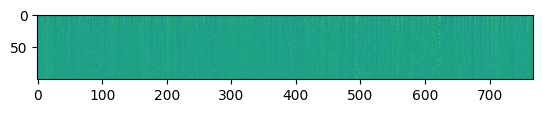

In [123]:
plt.imshow((decoder_output - hf_outputs["last_hidden_state"])[0])

## Full decoder

In [686]:
with torch.no_grad():
    encoder_out = orig_model.forward_text_encoder(src_tokens)
    
ys = torch.randn(1, 3, 80)
#ys = torch.randn(1, 1, 80)    

In [124]:
with torch.no_grad():
    encoder_out = orig_model.forward_text_encoder(input_ids_batch)
    
# ys = torch.randn(3, 1, 80)
# ys = torch.randn(3, 76, 80)
ys = torch.zeros(3, 7, 80)

In [125]:
spkembs = torch.randn(ys.size(0), 512)
incremental_states = None

In [126]:
# with torch.no_grad():
#     decoder_in, _ = orig_model.speech_decoder_prenet(ys, spkembs=spkembs)
#     z, extra = orig_model.decoder(
#         decoder_in[:,-1:], None, encoder_out, incremental_states, alignment_layer=-1
#     )

In [127]:
# Need to test this by padding the entire sequence into orig_model.decoder,
# since that's what hf_model.speecht5.decoder does too.
with torch.no_grad():
    decoder_in, _ = orig_model.speech_decoder_prenet(ys, spkembs=spkembs)
    z, extra = orig_model.decoder(
        decoder_in, None, encoder_out, incremental_states, alignment_layer=-1
    )

In [128]:
decoder_in.shape, decoder_in[:,-1:].shape

(torch.Size([3, 7, 768]), torch.Size([3, 1, 768]))

In [129]:
z.shape

torch.Size([3, 7, 768])

In [130]:
with torch.no_grad():
     hf_outputs = hf_model.speecht5.decoder(
         input_values=ys,
         #attention_mask=decoder_attention_mask,
         encoder_hidden_states=encoder_out["encoder_out"][0].permute((1, 0, 2)),
#         encoder_attention_mask=(1.0 - encoder_out["encoder_padding_mask"][0] * 1.0),
         encoder_attention_mask=attention_mask_batch,
         speaker_embeddings=spkembs,
         return_dict=True,         
     )

type(hf_outputs)

transformers.modeling_outputs.BaseModelOutputWithPastAndCrossAttentions

In [131]:
hf_outputs.last_hidden_state.shape

torch.Size([3, 7, 768])

In [132]:
torch.max(torch.abs(z - hf_outputs["last_hidden_state"]))

tensor(2.3842e-06)

In [133]:
for i in range(input_ids_batch.size(0)):
    print(i, torch.max(torch.abs(z[i] - hf_outputs.last_hidden_state[i])))

0 tensor(1.9073e-06)
1 tensor(2.3842e-06)
2 tensor(2.3842e-06)


## Verify speech decoder postnet output

In [134]:
z.shape, z[0, -1].shape

(torch.Size([3, 7, 768]), torch.Size([768]))

In [135]:
#orig_model.speech_decoder_postnet

In [136]:
# hf_model.speech_decoder_postnet

In [137]:
with torch.no_grad():
    before_outs, after_outs, logits = orig_model.speech_decoder_postnet(z)  # z[:, -1])
    
    # before_outs = speech_decoder_postnet.feat_out(...)
    # after_outs = final output
    # logits = speech_decoder_postnet.prob_out(...)  for stop token

In [138]:
before_outs.shape, after_outs.shape, logits.shape

(torch.Size([3, 14, 80]), torch.Size([3, 14, 80]), torch.Size([3, 14]))

In [139]:
logits[0]

tensor([-24.1840, -10.6777, -22.3951, -12.5376, -22.7592, -11.0522, -22.7133,
        -10.3976, -22.8957, -10.1333, -23.1024, -10.3960, -23.3082, -10.8343])

In [140]:
hf_outputs.last_hidden_state.shape

torch.Size([3, 7, 768])

In [141]:
with torch.no_grad():
    before_outs_hf, after_outs_hf, logits_hf = hf_model.speech_decoder_postnet(z)

In [142]:
before_outs_hf.shape, after_outs_hf.shape, logits_hf.shape

(torch.Size([3, 14, 80]), torch.Size([3, 14, 80]), torch.Size([3, 14]))

In [143]:
torch.max(torch.abs(before_outs - before_outs_hf))

tensor(0.)

In [144]:
torch.max(torch.abs(after_outs - after_outs_hf))

tensor(0.)

In [145]:
torch.max(torch.abs(logits - logits_hf))

tensor(0.)

## Complete forward pass

I think this is only used during training / fine-tuning, not inference.

In [146]:
spkembs = torch.randn((1, 512))

with torch.no_grad():
    hf_outputs = hf_model(
        input_ids=src_tokens,
        attention_mask=attention_mask,
        decoder_input_values=torch.zeros((1, 7, 80)),
        speaker_embeddings=spkembs,
        return_dict=True
    )

In [147]:
list(hf_outputs.keys())

['logits', 'past_key_values', 'encoder_last_hidden_state']

In [148]:
hf_outputs["encoder_last_hidden_state"].shape

torch.Size([1, 79, 768])

In [149]:
hf_outputs["logits"].shape

torch.Size([1, 14, 80])

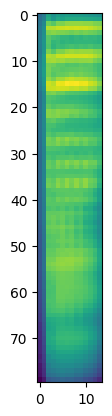

In [150]:
plt.imshow(hf_outputs["logits"][0].T)

In [151]:
with torch.no_grad():
    outputs = orig_model(
        src_tokens=src_tokens,
        prev_output_tokens=torch.zeros((1, 7, 80)),
        spkembs=spkembs,        
    )

In [152]:
outputs[0].shape  # which one is this? (targets maybe?)

torch.Size([1, 14, 80])

In [153]:
torch.max(torch.abs(outputs[1] - hf_outputs["logits"]))

tensor(0.)

Batch:

In [10]:
spkembs = torch.randn((input_ids_batch.size(0), 512))

In [11]:
with torch.no_grad():
    hf_outputs = hf_model(
        input_ids=input_ids_batch,
        attention_mask=attention_mask_batch,
        decoder_input_values=torch.zeros((input_ids_batch.size(0), 7, 80)),
        speaker_embeddings=spkembs,
        return_dict=True
    )

In [13]:
type(hf_outputs)

transformers.modeling_outputs.Seq2SeqSpectrogramOutput

In [12]:
hf_outputs[0].shape

torch.Size([3, 14, 80])

In [157]:
with torch.no_grad():
    outputs = orig_model(
        src_tokens=input_ids_batch,
        prev_output_tokens=torch.zeros((input_ids_batch.size(0), 7, 80)),
        spkembs=spkembs,        
        #task_name="t2s",
    )

In [158]:
outputs[1].shape

torch.Size([3, 14, 80])

In [159]:
for i in range(input_ids_batch.size(0)):
    print(i, torch.max(torch.abs(outputs[1][i] - hf_outputs["logits"][i])))

0 tensor(2.0266e-06)
1 tensor(2.2650e-06)
2 tensor(2.3916e-06)


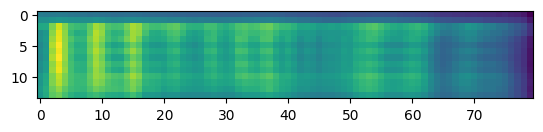

In [160]:
plt.imshow(hf_outputs["logits"][1])

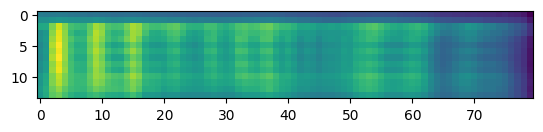

In [161]:
plt.imshow(outputs[1][1])

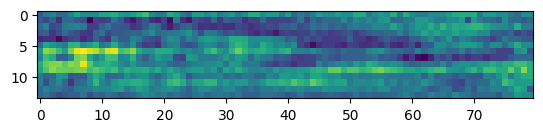

In [162]:
plt.imshow(hf_outputs["logits"][1] - outputs[1][1])

Without `input_ids` but previous encoder state:

In [163]:
encoder_last_hidden_state = hf_outputs.encoder_last_hidden_state

In [164]:
with torch.no_grad():
    hf_outputs = hf_model(
        encoder_outputs=(encoder_last_hidden_state,),
        attention_mask=attention_mask_batch,
        decoder_input_values=hf_outputs["logits"], #torch.zeros((1, 10, 80)),
        speaker_embeddings=torch.randn((encoder_last_hidden_state.size(0), 512)),
        return_dict=True
    )

In [165]:
list(hf_outputs.keys())

['logits', 'past_key_values', 'encoder_last_hidden_state']

In [166]:
hf_outputs["encoder_last_hidden_state"].shape

torch.Size([3, 79, 768])

In [167]:
hf_outputs["logits"].shape

torch.Size([3, 28, 80])

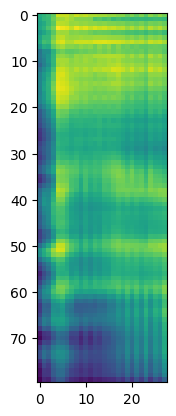

In [168]:
plt.imshow(hf_outputs["logits"][0].T)

Calculate loss:

In [ ]:
with torch.no_grad():
     hf_outputs = hf_model(
         input_values=inputs.input_values,
         attention_mask=inputs.attention_mask,
         #decoder_input_ids=torch.tensor([[2,  4, 18, 10, 12,  6,  5]]),
         labels=torch.tensor([[4, 18, 10, 12,  6,  5, 13]]),
         #labels=torch.tensor([[4, 18, 10, 12,  6,  5, 13], [4, 18, 10, 12,  6,  5, 13]]),  # batch
     )

In [ ]:
# TODO loss!

## Generating speech

The original repo comes with a `generate_speech.py` script. This is used instead of the typical encoder-decoder generation loop.

What this script does:

- create SpeechT5 task
- load the model checkpoint
- load the dataset
- create an iterator for the examples in the dataset
- loop through the iterator and call `task.generate_speech()` on each example
- save the predicted features to a numpy file
- save some spectrogram plots

The example that goes into `task.generate_speech()` is already tokenized. This is done by the dataset.

`task.generate_speech()` calls `model.generate_speech()` on the T5TransformerModel.

Dataset (`text_to_speech_dataset.py`):

- `__getitem__`:
    - calls `get_labels` which gets the text and tokenizes it
    - calls `get_audio` to load the target audio file and converts it to log-mel spectrograms
    - calls `get_features_or_waveform` to load the speaker embeddings from NumPy files (= 512-element vector)
    
- `collater`:
    - thins out frames of the target spectrogram for reduction factor (= 2)
    - creates `prev_output_tokens` by shifting the target spectrogram
    - creates labels for stop token prediction (tensor with same size as spectrogram that is all zero except for final element, which is 1)
    - pads everything to fit in a mini-batch

We don't need the target audio.

In [26]:
text = "Hey, what's up, Hugging Face? This is Speech tee five talking to you for real."

In [27]:
label = tokenizer.encode(text)
src_tokens = label_processor(label)
src_tokens = src_tokens.unsqueeze(0)
src_tokens

tensor([[ 4, 35,  5, 22, 23,  4, 20, 11,  7,  6, 31, 12,  4, 16, 24, 23,  4, 35,
         16, 21, 21, 10,  9, 21,  4, 55,  7, 17,  5, 41,  4, 32, 11, 10, 12,  4,
         10, 12,  4, 34, 24,  5,  5, 17, 11,  4,  6,  5,  5,  4, 19, 10, 27,  5,
          4,  6,  7, 15, 28, 10,  9, 21,  4,  6,  8,  4, 22,  8, 16,  4, 19,  8,
         13,  4, 13,  5,  7, 15, 26]], dtype=torch.int32)

In [28]:
src_tokens = hf_tokenizer(text, return_tensors="pt")["input_ids"]
src_tokens

tensor([[ 4, 35,  5, 22, 23,  4, 20, 11,  7,  6, 31, 12,  4, 16, 24, 23,  4, 35,
         16, 21, 21, 10,  9, 21,  4, 55,  7, 17,  5, 41,  4, 32, 11, 10, 12,  4,
         10, 12,  4, 34, 24,  5,  5, 17, 11,  4,  6,  5,  5,  4, 19, 10, 27,  5,
          4,  6,  7, 15, 28, 10,  9, 21,  4,  6,  8,  4, 22,  8, 16,  4, 19,  8,
         13,  4, 13,  5,  7, 15, 26]])

In [29]:
# xvector = "1272-128104.npy"
# xvector = "711-187464.npy"
# spkembs_path = "/Users/matthijs/Documents/FILES/HuggingFace/SpeechT5/tryout/AUDIO_DIR/dev_clean/xvectors/" + xvector

spkembs_path = "/Users/matthijs/Downloads/LibriTTS_16k/spkrec-xvect/4992-23283-4992_23283_000025_000001.npy"

spkembs = torch.from_numpy(np.load(spkembs_path)).float()
spkembs = spkembs.unsqueeze(0)
spkembs.shape

torch.Size([1, 512])

In [30]:
threshold = 0.5
minlenratio = 0.0
maxlenratio = 20.0
reduction_factor = 2

### The loop from the original code

In [48]:
with torch.no_grad():
    encoder_out = orig_model.forward_text_encoder(src_tokens)
list(encoder_out.keys())

['encoder_out',
 'encoder_padding_mask',
 'encoder_states',
 'src_tokens',
 'decoder_input',
 'encoder_out_for_ctc']

This part is skipped, since `spk_embed_integration_type == "pre"`:

In [40]:
maxlen = int(encoder_out["encoder_out"][0].size(0) * maxlenratio / reduction_factor)
minlen = int(encoder_out["encoder_out"][0].size(0) * minlenratio / reduction_factor)
maxlen, minlen

(790, 0)

In [41]:
ys = encoder_out["encoder_out"][0].new_zeros(1, 1, orig_model.speech_decoder_postnet.odim)

outs, probs = [], []

incremental_states = {}
attns = []

idx = 0

# for debugging
zs = []
decoder_ins = []

with torch.no_grad():
    while True:
        # update index
        idx += 1

        # calculate output and stop prob at idx-th step
        decoder_in, _ = orig_model.speech_decoder_prenet(ys, spkembs=spkembs)
        decoder_ins.append(decoder_in)
        
        z, extra = orig_model.decoder(
            decoder_in[:, -1:], None, encoder_out, incremental_states, alignment_layer=-1
        )
        
        zs.append(z)  # debugging only
        
        outs += [
            orig_model.speech_decoder_postnet.feat_out(z[0, -1]).view(
                reduction_factor, orig_model.speech_decoder_postnet.odim)
        ]  # [(r, odim), ...]
        
        probs += [torch.sigmoid(orig_model.speech_decoder_postnet.prob_out(z[0, -1]))]  # [(r), ...]

        # update next inputs
        ys = torch.cat((ys, outs[-1][-1].view(1, 1, orig_model.speech_decoder_postnet.odim)), dim=1)  # (1, idx + 1, odim)
        attns.append(torch.stack([att_l[0] for att_l in extra['attn'][0]], dim=0))
        

        # check whether to finish generation
        if int(sum(probs[-1] >= threshold)) > 0 or idx >= maxlen:
            # check mininum length
            if idx < minlen:
                continue
            outs = (torch.cat(outs, dim=0).unsqueeze(0).transpose(1, 2))  # (L, odim) -> (1, L, odim) -> (1, odim, L)
            
            if orig_model.speech_decoder_postnet.postnet is not None:
                outs = outs + orig_model.speech_decoder_postnet.postnet(outs)  # (1, odim, L)
            outs = outs.transpose(2, 1).squeeze(0)  # (L, odim)
            probs = torch.cat(probs, dim=0)
            attn = torch.cat(attns, dim=2)
            break

    # if outs.size(0) == maxlen:
    #     logging.warning("output length reaches maximum length")
    # return outs, probs, attn

In [42]:
idx

125

In [43]:
outs.shape, probs.shape, attn.shape

(torch.Size([250, 80]), torch.Size([250]), torch.Size([6, 12, 125, 79]))

In [44]:
# outs

In [45]:
# probs

In [46]:
# np.save("/Users/matthijs/Documents/FILES/HuggingFace/SpeechT5/tryout/RESULTS_PATH_TTS/test-feats.npy", outs)

In [47]:
output_from_orig = np.load("/Users/matthijs/Documents/FILES/HuggingFace/SpeechT5/tryout/RESULTS_PATH_TTS/1272-141231-0020-feats.npy")
output_from_orig.shape

(246, 80)

In [48]:
output_from_orig

array([[-2.473754 , -2.6110775, -2.6744287, ..., -3.4291997, -3.4861205,
        -3.7170238],
       [-2.3763716, -2.483789 , -2.5290115, ..., -3.335082 , -3.3697302,
        -3.658468 ],
       [-2.2457216, -2.3389206, -2.3680828, ..., -3.2389064, -3.2980084,
        -3.5808692],
       ...,
       [-1.9134729, -1.4292057, -0.9842132, ..., -3.1504958, -3.1947155,
        -3.484864 ],
       [-2.0729182, -1.583269 , -1.2519165, ..., -3.1911037, -3.2313066,
        -3.508048 ],
       [-2.2312534, -1.8440536, -1.6086199, ..., -3.1966043, -3.2362816,
        -3.5100303]], dtype=float32)

In [49]:
np.max(np.abs(output_from_orig - outs.numpy()))

ValueError: operands could not be broadcast together with shapes (246,80) (250,80) 

### The loop using the HF model

In [31]:
outs_hf = hf_model.generate_speech(src_tokens, spkembs, vocoder=None)

In [32]:
outs_hf.shape

torch.Size([260, 80])

In [33]:
from transformers import SpeechT5HiFiGAN

vocoder = SpeechT5HiFiGAN.from_pretrained("/Users/matthijs/Documents/FILES/HuggingFace/SpeechT5/weights/hifigan")

In [34]:
outs_hf = hf_model.generate_speech(src_tokens, spkembs, vocoder=vocoder)

In [35]:
outs_hf.shape

torch.Size([67072])

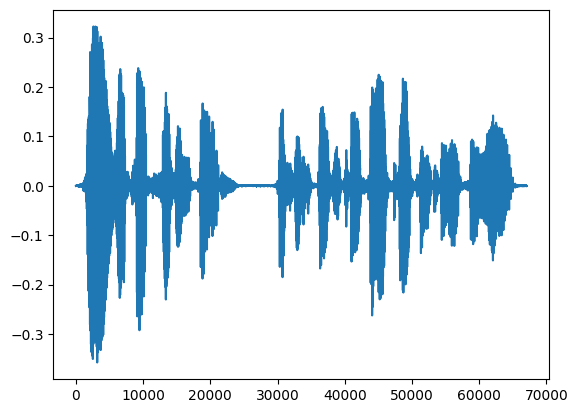

In [36]:
plt.plot(outs_hf.view(-1))

In [39]:
import soundfile as sf
sf.write("../gen.wav", outs_hf.cpu().numpy(), 16000, "PCM_16")

In [38]:
from IPython.display import Audio

Audio(data=outs_hf.numpy(), rate=16000)

In [50]:
# torch.max(torch.abs(outs - outs_hf))

In [185]:
# torch.max(torch.abs(probs - probs_hf))

In [186]:
np.max(np.abs(output_from_orig - outs_hf.numpy()))

0.0

**Note:** If we don't do `use_cache=True`, the outputs are not 100% identical. The error for the outputs is in the range 1e-6. This is because the decoder looks at the entire sequence rather than just the last element, and will accumulate floating-point precision errors.

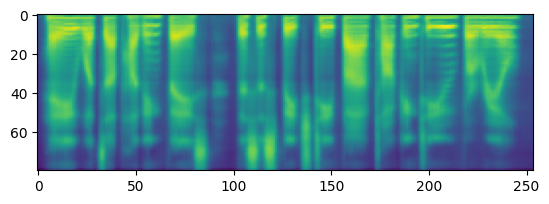

In [70]:
plt.imshow(outs_hf.T)

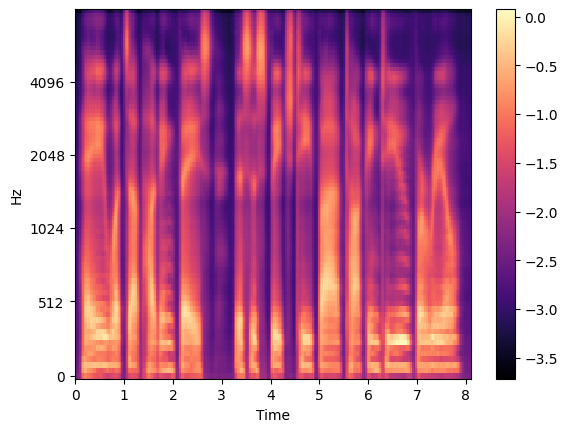

In [71]:
import librosa.display

plt.figure()
librosa.display.specshow(outs_hf.T.numpy(), sr=16000, x_axis="time", y_axis="mel")
plt.colorbar()
plt.show()

In [72]:
np.save("/Users/matthijs/Documents/FILES/HuggingFace/SpeechT5/tryout/RESULTS_PATH_TTS/hf-feats.npy", outs_hf)

## Vocoder

## Use the `transformers` generator loop

I don't think this makes sense for the TTS model. It needs to run the decoder in a specific way that's different from what `model.generate()` does.

## Other functionality

In [189]:
type(hf_model)

transformers.models.speecht5.modeling_speecht5.SpeechT5ForTTS

In [190]:
hf_model.get_input_embeddings()

Embedding(81, 768, padding_idx=1)

In [191]:
hf_model.get_output_embeddings()

In [611]:
hf_model.resize_token_embeddings(100)

Embedding(100, 768)

In [612]:
hf_model.get_input_embeddings()

Embedding(100, 768)

## For debugging

Restart kernel, then reload the models:

In [3]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, "../SpeechT5/SpeechT5")
sys.path.insert(0, "../SpeechT5/SpeechT5/fairseq")

import numpy as np
import torch
import matplotlib.pyplot as plt

from argparse import Namespace
from fairseq.data import encoders

bpe_tokenizer_path = "/Users/matthijs/Documents/FILES/HuggingFace/SpeechT5/tryout/MODEL_DIR/spm_char.model"
tokenizer = encoders.build_bpe(Namespace(**{"bpe": "sentencepiece", "sentencepiece_model": bpe_tokenizer_path}))

from fairseq.data import Dictionary
src_dict = Dictionary.load("/Users/matthijs/Documents/FILES/HuggingFace/SpeechT5/tryout/DATA_ROOT/dict.txt")
src_dict.add_symbol("<mask>")
src_dict.add_symbol("<ctc_blank>")
print(f"dictionary size: " f"{len(src_dict):,}")

from fairseq.tasks.hubert_pretraining import LabelEncoder
label_processor = LabelEncoder(src_dict)

text = "Hey, what's up, Hugging Face? This is Speech tee five talking to you for real."

label = tokenizer.encode(text)
label

src_tokens = label_processor(label).unsqueeze(0)
src_tokens

attention_mask = torch.ones_like(src_tokens)
attention_mask.shape

text2 = "A much shorter snippet"
label2 = tokenizer.encode(text2)
src_tokens2 = label_processor(label2).unsqueeze(0)
src_tokens2

pad_token_id = 1
pad_length = src_tokens.size(-1) - src_tokens2.size(-1)
src_tokens2_padded = torch.cat([src_tokens2, torch.ones(1, pad_length).long() * pad_token_id], dim=1)
attention_mask2 = torch.cat([torch.ones_like(src_tokens2), torch.zeros(1, pad_length).long()], dim=1)

input_ids_batch = torch.cat([src_tokens, src_tokens2_padded, src_tokens.clone()])
attention_mask_batch = torch.cat([attention_mask, attention_mask2, attention_mask.clone()])

from transformers import (
    SpeechT5Config, 
    SpeechT5CTCTokenizer,
    SpeechT5Processor,
    SpeechT5Model, 
    SpeechT5ForTextToSpeech, 
)

model_checkpoint = "/Users/matthijs/Documents/FILES/HuggingFace/SpeechT5/weights/speecht5_tts"

hf_model = SpeechT5ForTextToSpeech.from_pretrained(model_checkpoint)

hf_model.eval()

from fairseq.data import Dictionary
tgt_dict = Dictionary.load("/Users/matthijs/Documents/FILES/HuggingFace/SpeechT5/tryout/DATA_ROOT/dict.txt")
tgt_dict.add_symbol("<mask>")
tgt_dict.add_symbol("<ctc_blank>")
print(f"dictionary size: " f"{len(tgt_dict):,}")


class FakeTask:
    def __init__(self):
        self.dicts = { "text": tgt_dict }
        self.t5_task = "t2s"
        
task = FakeTask()

import torch
from speecht5.models.speecht5 import T5TransformerModel

checkpoint = torch.load("../weights/speecht5-tts/speecht5_tts.pt")

orig_model = T5TransformerModel.build_model(checkpoint["cfg"]["model"], task)

orig_model.load_state_dict(checkpoint["model"])
orig_model = orig_model.eval()

from fairseq.data import encoders
from argparse import Namespace
tokenizer = encoders.build_bpe(
    Namespace(
        bpe='sentencepiece', 
        sentencepiece_model='/Users/matthijs/Documents/FILES/HuggingFace/SpeechT5/tryout/MODEL_DIR/spm_char.model'
    )
)
type(tokenizer)

dictionary size: 81
dictionary size: 81


fairseq.data.encoders.sentencepiece_bpe.SentencepieceBPE